In [1]:
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
from tqdm import tqdm

In [2]:
torch_device = "cuda:0"

In [3]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet"
)

# The noise scheduler
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['visual_projection.weight', 'vision_model.encoder.layers.18.layer_norm1.bias', 'vision_model.encoder.layers.23.self_attn.q_proj.bias', 'vision_model.encoder.layers.5.self_attn.k_proj.weight', 'vision_model.encoder.layers.23.layer_norm1.bias', 'vision_model.encoder.layers.21.mlp.fc2.weight', 'vision_model.encoder.layers.13.mlp.fc1.weight', 'vision_model.encoder.layers.16.mlp.fc2.weight', 'vision_model.encoder.layers.20.mlp.fc1.bias', 'vision_model.encoder.layers.19.layer_norm2.bias', 'vision_model.encoder.layers.6.layer_norm1.bias', 'vision_model.encoder.layers.12.layer_norm1.bias', 'vision_model.encoder.layers.7.self_attn.v_proj.bias', 'vision_model.encoder.layers.3.layer_norm1.bias', 'vision_model.encoder.layers.16.layer_norm1.bias', 'vision_model.encoder.layers.4.self_attn.k_proj.weight', 'vision_model.encoder.layers.20.self_attn.out_proj.weight', 'vision_model.encode

In [4]:
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)

In [5]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(
        bsz, seq_len, dtype=input_embeddings.dtype
    )

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None,  # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True,  # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [99]:
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)


def latents_to_np(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")

    return images

In [7]:
def generate_with_embs(text_embeddings, text_input):
    height = 512  # default height of Stable Diffusion
    width = 512  # default width of Stable Diffusion
    num_inference_steps = 30  # Number of denoising steps
    guidance_scale = 7.5  # Scale for classifier-free guidance
    generator = torch.manual_seed(
        32
    )  # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt",
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
        (batch_size, unet.in_channels, height // 8, width // 8),
        generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(
                latent_model_input, t, encoder_hidden_states=text_embeddings
            )["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (
            noise_pred_text - noise_pred_uncond
        )

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [136]:
birb_embed = torch.load("./concept_libs/oil_style.bin")

In [131]:
prompt = "A mouse in the style of CS"
text_input = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)

In [10]:
text_input.input_ids[0]

tensor([49406,   320,  9301,   530,   518,  1844,   539,  2804, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [11]:
for token in text_input.input_ids[0][:10]:
    print(token, tokenizer.decode(token))

tensor(49406) <|startoftext|>
tensor(320) a
tensor(9301) mouse
tensor(530) in
tensor(518) the
tensor(1844) style
tensor(539) of
tensor(2804) cs
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


In [28]:
custom_style_token = tokenizer.encode("cs", add_special_tokens=False)[0]

/tmp/ipykernel_1655065/2604073039.py:27: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
100%|██████████| 30/30 [00:03<00:00,  8.84it/s]


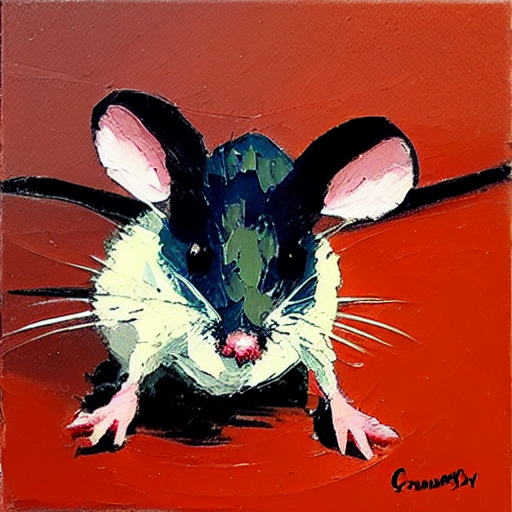

In [139]:
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding - our special birb word
replacement_token_embedding = birb_embed["oil_style"]

# Insert this into the token embeddings
token_embeddings[
    0, torch.where(input_ids[0] == custom_style_token)
] = replacement_token_embedding.to(torch_device)
# token_embeddings = token_embeddings + (replacement_token_embedding * 0.9)
# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# And generate an image with this:
generate_with_embs(modified_output_embeddings, text_input)

In [113]:
def loss_fn(images):
    error1 = torch.abs(images[:, 0] - 0.9)
    error2 = torch.abs(images[:, 1] - 0.9)
    error3 = torch.abs(images[:, 2] - 0.9)
    return (
        torch.sin(error1.mean()) + torch.sin(error2.mean()) + torch.sin(error3.mean())
    ) / 3

In [83]:
custom_embed = torch.load("./concept_libs/birb_style.bin")
embed_key = list(custom_embed.keys())[0]

In [107]:
def generate_image(prompt, guidance_scale, loss_fn, custom_embed, embed_key):
    # prompt = "A german shephard in the style of cs"  # @param
    height = 512  # default height of Stable Diffusion
    width = 512  # default width of Stable Diffusion
    num_inference_steps = 50  # @param           # Number of denoising steps
    # guidance_scale = 8  # @param               # Scale for classifier-free guidance
    generator = torch.manual_seed(
        32
    )  # Seed generator to create the inital latent noise
    batch_size = 1
    blue_loss_scale = 200  # @param

    # Prep text
    text_input = tokenizer(
        [prompt],
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    custom_style_token = tokenizer.encode("cs", add_special_tokens=False)[0]

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
        replacement_token_embedding = custom_embed[embed_key]

        # Insert this into the token embeddings
        text_embeddings[
            0, torch.where(text_input.input_ids[0] == custom_style_token)
        ] = replacement_token_embedding.to(torch_device)

    # And the uncond. input as before:
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt",
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
        (batch_size, unet.in_channels, height // 8, width // 8),
        generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(
                latent_model_input, t, encoder_hidden_states=text_embeddings
            )["sample"]

        # perform CFG
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (
            noise_pred_text - noise_pred_uncond
        )

        #### ADDITIONAL GUIDANCE ###
        if i % 5 == 0:
            # Requires grad on the latents
            latents = latents.detach().requires_grad_()

            # Get the predicted x0:
            # latents_x0 = latents - sigma * noise_pred
            latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

            # Decode to image space
            denoised_images = (
                vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5
            )  # range (0, 1)

            # Calculate loss
            loss = loss_fn(denoised_images) * blue_loss_scale

            # Occasionally print it out
            if i % 10 == 0:
                print(i, "loss:", loss.item())

            # Get gradient
            cond_grad = torch.autograd.grad(loss, latents)[0]

            # Modify the latents based on this gradient
            latents = latents.detach() - cond_grad * sigma**2
            scheduler._step_index = scheduler._step_index - 1

        # Now step with scheduler
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_np(latents)[0]

In [108]:
import pathlib
import matplotlib.pyplot as plt

In [128]:
prompt = "a cat and dog in the style of cs"
guidance_scale = 20
generated_images = []
for concept_lib in pathlib.Path("./concept_libs/").iterdir():
    custom_embed = torch.load(concept_lib)
    embed_key = list(custom_embed.keys())[0]

    image = generate_image(prompt, guidance_scale, loss_fn, custom_embed, embed_key)
    generated_images.append((concept_lib.name.split(".")[0], image))

/tmp/ipykernel_1655065/2577740460.py:49: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  4%|▍         | 2/50 [00:00<00:08,  5.58it/s]

0 loss: 108.3358154296875


 24%|██▍       | 12/50 [00:01<00:05,  6.41it/s]

10 loss: 68.75717163085938


 44%|████▍     | 22/50 [00:03<00:04,  6.40it/s]

20 loss: 58.225868225097656


 62%|██████▏   | 31/50 [00:04<00:03,  5.91it/s]

30 loss: 55.11540603637695


 84%|████████▍ | 42/50 [00:06<00:01,  6.34it/s]

40 loss: 54.42686080932617


  4%|▍         | 2/50 [00:00<00:08,  5.58it/s]

0 loss: 108.2776870727539


 22%|██▏       | 11/50 [00:01<00:06,  5.93it/s]

10 loss: 71.33706665039062


 44%|████▍     | 22/50 [00:03<00:04,  6.32it/s]

20 loss: 57.23241424560547


 64%|██████▍   | 32/50 [00:04<00:02,  6.37it/s]

30 loss: 54.410396575927734


 84%|████████▍ | 42/50 [00:06<00:01,  6.36it/s]

40 loss: 53.897605895996094


  4%|▍         | 2/50 [00:00<00:08,  5.97it/s]

0 loss: 96.88143157958984


 24%|██▍       | 12/50 [00:01<00:06,  6.32it/s]

10 loss: 77.45528411865234


 44%|████▍     | 22/50 [00:03<00:04,  6.25it/s]

20 loss: 61.412437438964844


 64%|██████▍   | 32/50 [00:04<00:02,  6.36it/s]

30 loss: 60.403358459472656


 82%|████████▏ | 41/50 [00:06<00:01,  5.77it/s]

40 loss: 60.28227996826172


  4%|▍         | 2/50 [00:00<00:08,  5.96it/s]

0 loss: 108.37060546875


 24%|██▍       | 12/50 [00:01<00:05,  6.36it/s]

10 loss: 68.17378997802734


 44%|████▍     | 22/50 [00:03<00:04,  6.36it/s]

20 loss: 57.59922790527344


 64%|██████▍   | 32/50 [00:04<00:02,  6.45it/s]

30 loss: 55.06040954589844


 84%|████████▍ | 42/50 [00:06<00:01,  6.23it/s]

40 loss: 54.45984649658203


100%|██████████| 50/50 [00:07<00:00,  6.88it/s]


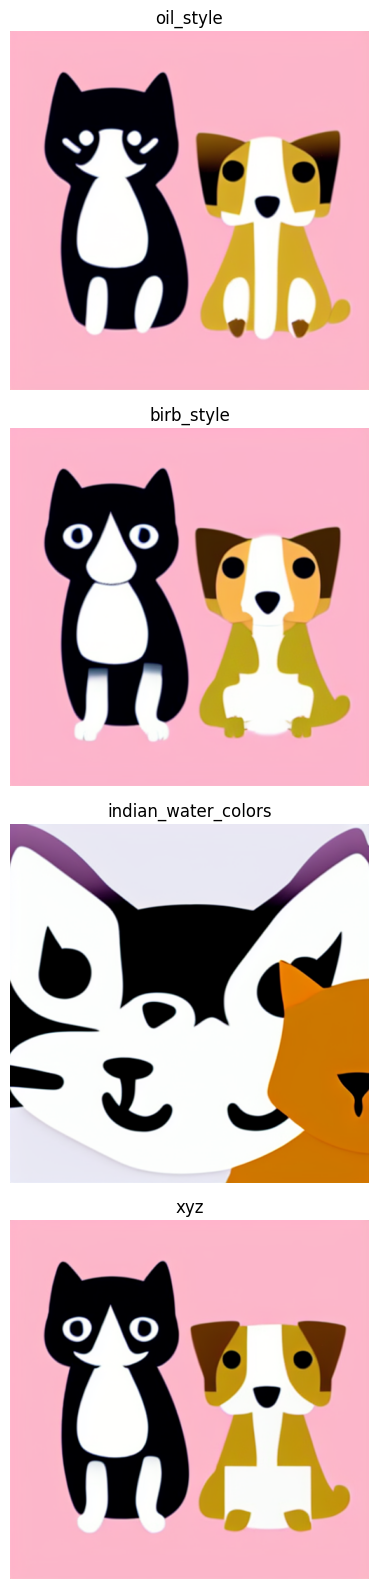

In [129]:
fig, axes = plt.subplots(len(generated_images), figsize=(24, 16))
for ax, (label, image) in zip(axes, generated_images):
    ax.imshow(image)
    ax.set_title(label)
    ax.axis("off")
plt.tight_layout()
plt.show()